In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [20]:
# Load dataset
df = pd.read_csv('telcom_data.csv')

In [21]:
df.columns = [col.strip().replace(' ', '_').replace('.', '') for col in df.columns]

In [22]:
df.shape

(150001, 55)

In [23]:
df.columns

Index(['Bearer_Id', 'Start', 'Start_ms', 'End', 'End_ms', 'Dur_(ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last_Location_Name', 'Avg_RTT_DL_(ms)',
       'Avg_RTT_UL_(ms)', 'Avg_Bearer_TP_DL_(kbps)', 'Avg_Bearer_TP_UL_(kbps)',
       'TCP_DL_Retrans_Vol_(Bytes)', 'TCP_UL_Retrans_Vol_(Bytes)',
       'DL_TP_<_50_Kbps_(%)', '50_Kbps_<_DL_TP_<_250_Kbps_(%)',
       '250_Kbps_<_DL_TP_<_1_Mbps_(%)', 'DL_TP_>_1_Mbps_(%)',
       'UL_TP_<_10_Kbps_(%)', '10_Kbps_<_UL_TP_<_50_Kbps_(%)',
       '50_Kbps_<_UL_TP_<_300_Kbps_(%)', 'UL_TP_>_300_Kbps_(%)',
       'HTTP_DL_(Bytes)', 'HTTP_UL_(Bytes)', 'Activity_Duration_DL_(ms)',
       'Activity_Duration_UL_(ms)', 'Dur_(ms)1', 'Handset_Manufacturer',
       'Handset_Type', 'Nb_of_sec_with_125000B_<_Vol_DL',
       'Nb_of_sec_with_1250B_<_Vol_UL_<_6250B',
       'Nb_of_sec_with_31250B_<_Vol_DL_<_125000B',
       'Nb_of_sec_with_37500B_<_Vol_UL',
       'Nb_of_sec_with_6250B_<_Vol_DL_<_31250B',
       'Nb_of_sec_with_6250B_<_Vol_UL_<_37500B',
     

In [24]:
# Convert columns to numeric as needed
df['Dur_(ms)'] = pd.to_numeric(df['Dur_(ms)'], errors='coerce')
df['Total_DL_(Bytes)'] = pd.to_numeric(df['Total_DL_(Bytes)'], errors='coerce')
df['Total_UL_(Bytes)'] = pd.to_numeric(df['Total_UL_(Bytes)'], errors='coerce')

# Aggregate metrics by MSISDN
agg_df = df.groupby('MSISDN/Number').agg({
    'Bearer_Id': 'count',
    'Dur_(ms)': 'sum',
    'Total_DL_(Bytes)': 'sum',
    'Total_UL_(Bytes)': 'sum'
}).rename(columns={
    'Bearer_Id': 'session_count',
    'Dur_(ms)': 'total_duration',
    'Total_DL_(Bytes)': 'total_download',
    'Total_UL_(Bytes)': 'total_upload'
})

agg_df['total_traffic'] = agg_df['total_download'] + agg_df['total_upload']

In [25]:
# Top 10 users per metric
print("Top 10 by Session Count:")
print(agg_df.sort_values('session_count', ascending=False).head(10))

print("\nTop 10 by Total Duration:")
print(agg_df.sort_values('total_duration', ascending=False).head(10))

print("\nTop 10 by Total Traffic:")
print(agg_df.sort_values('total_traffic', ascending=False).head(10))

Top 10 by Session Count:
               session_count  total_duration  total_download  total_upload  \
MSISDN/Number                                                                
3.362632e+10              18       8791927.0    7.301517e+09   669650721.0   
3.362578e+10              17      18553754.0    7.770043e+09   729577380.0   
3.361489e+10              17       9966898.0    8.156743e+09   689483001.0   
3.365973e+10              16       4035428.0    7.081602e+09   624260321.0   
3.367588e+10              15       4865947.0    7.309542e+09   581568792.0   
3.376054e+10              15       9279434.0    7.811295e+09   703478581.0   
3.366716e+10              13       8744914.0    5.052068e+09   566326364.0   
3.376041e+10              12       5321667.0    6.610852e+09   521518890.0   
3.360452e+10              12       5207990.0    5.096079e+09   391775856.0   
3.360313e+10              12       6287761.0    4.540607e+09   435587631.0   

               total_traffic  
MSISDN/

In [26]:
# Normalize for clustering
scaler = MinMaxScaler()
scaled = scaler.fit_transform(agg_df[['session_count', 'total_duration', 'total_traffic']])

In [27]:
# KMeans Clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
agg_df['cluster'] = kmeans.fit_predict(scaled)

In [28]:
# Cluster statistics
cluster_summary = agg_df.groupby('cluster')[['session_count', 'total_duration', 'total_traffic']].agg(['min', 'max', 'mean', 'sum'])
print("\nCluster Summary:")
print(cluster_summary)



Cluster Summary:
        session_count                      total_duration              \
                  min max      mean    sum            min         max   
cluster                                                                 
0                   1   4  2.184791  46228        18235.0   3174824.0   
1                   3  18  4.258194  17020        49323.0  18553754.0   
2                   0   2  1.043550  85258         7142.0   1573420.0   

                                     total_traffic                \
                  mean           sum           min           max   
cluster                                                            
0        215100.806229  4.551318e+09  2.842182e+08  1.915933e+09   
1        572159.112084  2.286920e+09  1.085994e+09  8.846226e+09   
2        107473.680857  8.780600e+09  3.324901e+07  1.427100e+09   

                                     
                 mean           sum  
cluster                              
0        1.138979e+0

In [29]:
# Per-application traffic aggregation
apps = ['Social_Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']
for app in apps:
    df[f'{app}_total'] = pd.to_numeric(df[f'{app}_DL_(Bytes)'], errors='coerce') + pd.to_numeric(df[f'{app}_UL_(Bytes)'], errors='coerce')

app_traffic_df = df.groupby('MSISDN/Number')[[f'{app}_total' for app in apps]].sum()


In [30]:
# Top 10 users per app
top_users_per_app = app_traffic_df.apply(lambda col: col.sort_values(ascending=False).head(10))
print("\nTop 10 Users per Application:")
print(top_users_per_app)



Top 10 Users per Application:
               Social_Media_total  Google_total  Email_total  Youtube_total  \
MSISDN/Number                                                                 
3.360313e+10           23077825.0           NaN          NaN    284090139.0   
3.361489e+10           28294544.0   127973787.0   40788634.0    394370218.0   
3.362578e+10           27135500.0   142307915.0   40633966.0    452958769.0   
3.362632e+10           43374779.0   152191852.0   42418782.0    374483047.0   
3.362695e+10                  NaN           NaN          NaN            NaN   
3.362708e+10                  NaN           NaN          NaN    308790774.0   
3.365836e+10                  NaN           NaN          NaN            NaN   
3.365849e+10           23000066.0           NaN          NaN            NaN   
3.365973e+10           35412358.0   116516345.0   35999792.0            NaN   
3.366471e+10                  NaN           NaN          NaN            NaN   
3.366546e+10         

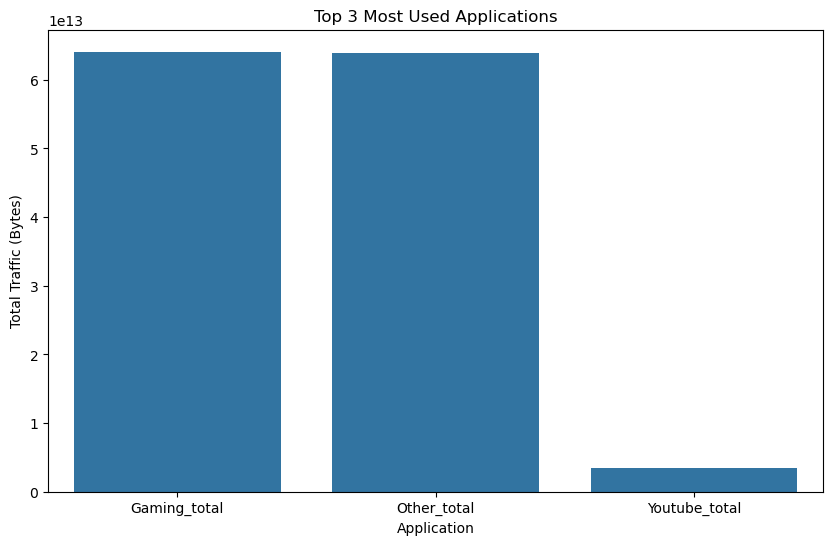

In [31]:
# Top 3 most used applications
top_apps = app_traffic_df.sum().sort_values(ascending=False).head(3)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_apps.index, y=top_apps.values)
plt.title('Top 3 Most Used Applications')
plt.ylabel('Total Traffic (Bytes)')
plt.xlabel('Application')
plt.show()

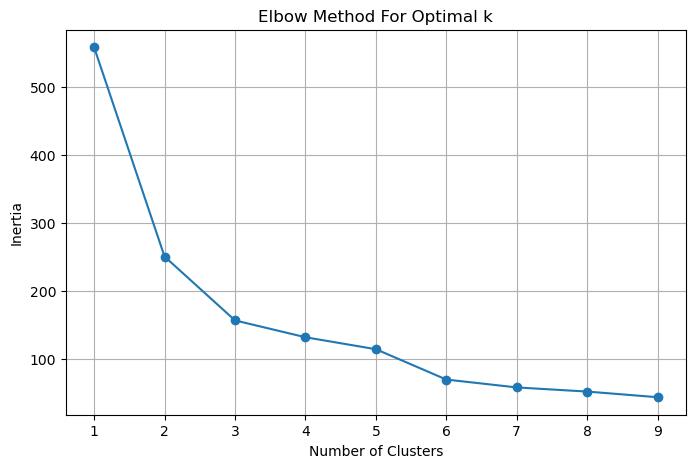

In [32]:
# Elbow method to find optimal k
inertias = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaler.fit_transform(agg_df[['session_count', 'total_duration', 'total_traffic']]))
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [33]:
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("telcom_analysis.log"), 
        logging.StreamHandler()
    ]
)

logger = logging.getLogger(__name__)

In [34]:
import logging

# Simple logger setup
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger()

logger.info("Loading dataset...")
df = pd.read_csv('telcom_data.csv')
logger.info("Dataset loaded.")

# Clean column names
df.columns = [col.strip().replace(' ', '_').replace('.', '') for col in df.columns]

# Convert columns
for col in ['Dur_(ms)', 'Total_DL_(Bytes)', 'Total_UL_(Bytes)']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    logger.info(f"Converted {col} to numeric.")

# Aggregate
logger.info("Aggregating data by MSISDN...")
agg_df = df.groupby('MSISDN/Number').agg({
    'Bearer_Id': 'count',
    'Dur_(ms)': 'sum',
    'Total_DL_(Bytes)': 'sum',
    'Total_UL_(Bytes)': 'sum'
}).rename(columns={
    'Bearer_Id': 'session_count',
    'Dur_(ms)': 'total_duration',
    'Total_DL_(Bytes)': 'total_download',
    'Total_UL_(Bytes)': 'total_upload'
})
agg_df['total_traffic'] = agg_df['total_download'] + agg_df['total_upload']
logger.info("Aggregation complete.")

# Clustering
logger.info("Starting KMeans clustering...")
scaler = MinMaxScaler()
scaled = scaler.fit_transform(agg_df[['session_count', 'total_duration', 'total_traffic']])
kmeans = KMeans(n_clusters=3, random_state=42)
agg_df['cluster'] = kmeans.fit_predict(scaled)
logger.info("Clustering done.")

# Summary
logger.info(f"Cluster counts:\n{agg_df['cluster'].value_counts()}")

# Done
logger.info("Script finished successfully.")


2025-09-20 12:57:12,816 - INFO - Loading dataset...
2025-09-20 12:57:13,478 - INFO - Dataset loaded.
2025-09-20 12:57:13,480 - INFO - Converted Dur_(ms) to numeric.
2025-09-20 12:57:13,483 - INFO - Converted Total_DL_(Bytes) to numeric.
2025-09-20 12:57:13,484 - INFO - Converted Total_UL_(Bytes) to numeric.
2025-09-20 12:57:13,486 - INFO - Aggregating data by MSISDN...
2025-09-20 12:57:13,509 - INFO - Aggregation complete.
2025-09-20 12:57:13,509 - INFO - Starting KMeans clustering...
2025-09-20 12:57:13,563 - INFO - Clustering done.
2025-09-20 12:57:13,564 - INFO - Cluster counts:
cluster
2    81700
0    21159
1     3997
Name: count, dtype: int64
2025-09-20 12:57:13,565 - INFO - Script finished successfully.
